In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import tt
 
def rs(f1, f2, f, vx_, N):
    for j in range(N):
        if (vx_[j] > 0.):
            f[j, :, :] = vx_[j] * f1[j, :, :]
        else:
            f[j, :, :] = vx_[j] * f2[j, :, :]
    return f
    
def minmod(a, b):
    return np.where((a*b > 0), np.where(((abs(a) <= abs(b)) & (a*b > 0)), a, b), 0)    
    
def minmod2(a, b):
    if ((abs(a) <= abs(b)) & (a*b > 0)):
        return a
    elif (a*b > 0):
        return b
    else:
        return 0

def maxmod(a, b):
    return np.where((a*b > 0), np.where(((abs(a) >= abs(b)) & (a*b > 0)), a, b), 0)

def minmod_lim(u):
    return minmod(u[1:-1] - u[:-2], u[2:] - u[1:-1])

def superbee(u):
    return maxmod(minmod(u[2:] - u[1:-1], 2*(u[1:-1] - u[:-2])),
                             minmod(2*(u[2:] - u[1:-1]), u[1:-1] - u[:-2]))

def F_m(vx, vy, vz, T, n, Mol):
    Rg = 8.3144598 / Mol
    return n * ((1. / (2. * np.pi * Rg * T)) ** (3. / 2.)) * (np.exp(-((vx)**2 + (vy)**2 + (vz)**2) / (2. * Rg * T)))

def J(f, vmax, N):
    #fundamental constants
    Na = 6.02214129e+23
    kB = 1.381e-23 # J / K
    
    #gas parameters
    Mol = 40e-3 # kg / mol
    Rg = 8.3144598  / Mol  # J / (kg * K) 
    m = Mol / Na # kg
    
    Pr = 2. / 3.
    C = 144.4
    T_0 = 273.11
    mu_0 = 2.125e-05

    #vmax = np.sqrt(2 * Rg * T) * 4
    #L = 21
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)

    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

    assert np.all(vx[:,0,0] == vx_)
    assert np.all(vy[0,:,0] == vx_)
    assert np.all(vz[0,0,:] == vx_)

    n = (hv ** 3) * np.sum(f)

    ux = (1. / n) * (hv ** 3) * np.sum(vx * f)
    uy = (1. / n) * (hv ** 3) * np.sum(vy * f)
    uz = (1. / n) * (hv ** 3) * np.sum(vz * f)
    
    v2 = vx*vx + vy*vy + vz*vz
    u2 = ux*ux + uy*uy + uz*uz
    
    T = (1. / (3. * n * Rg)) * ((hv ** 3) * np.sum(v2 * f) - n * u2)

    Vx = vx - ux
    Vy = vy - uy
    Vz = vz - uz

    rho = m * n

    p = rho * Rg * T

    cx = Vx / ((2. * Rg * T) ** (1. / 2.))
    cy = Vy / ((2. * Rg * T) ** (1. / 2.))
    cz = Vz / ((2. * Rg * T) ** (1. / 2.))
    
    c2 = cx*cx + cy*cy + cz*cz

    Sx = (1. / n) * (hv ** 3) * np.sum(cx * c2 * f)
    Sy = (1. / n) * (hv ** 3) * np.sum(cy * c2 * f)
    Sz = (1. / n) * (hv ** 3) * np.sum(cz * c2 * f)

    mu = mu_0 * ((T_0 + C) / (T + C)) * ((T / T_0) ** (3. / 2.))

    f_plus = F_m(Vx, Vy, Vz, T, n, Mol) * (1. + (4. / 5.) * (1. - Pr) * (cx*Sx + cy*Sy + cz*Sz) * (c2 - (5. / 2.)))

    J = (f_plus - f) * (p / mu)
    
    return J, n, ux, T

In [2]:
def solver(x_l, x_r, L, Tau, CFL, vmax, N, n_l, u_l, T_l):
    Mol = 40e-3
    g = 5. / 3.
    
    h = (x_r - x_l) / L 
    tau = h * CFL / vmax / 10
    
    x = np.linspace(x_l+h/2, x_r-h/2, L)
    
    t = 0.
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
    
    vx_l = np.zeros((N, N, N))
    vx_r = np.zeros((N, N, N))
    
    for i in np.ndindex(vx.shape):
        if vx[i] > 0:
            vx_l[i] = vx[i]
            vx_r[i] = 0.
        else:
            vx_l[i] = 0.
            vx_r[i] = vx[i]
    
    M = u_l / ((g * Rg * T_l) ** .5)
    
    n_r = (g + 1.) * M * M / ((g - 1.) * M * M + 2.) * n_l
    u_r = ((g - 1.) * M * M + 2.) / ((g + 1.) * M * M) * u_l
    T_r = (2. * g * M * M - (g - 1.)) * ((g - 1.) * M * M + 2.) / ((g + 1) ** 2 * M * M) * T_l
    
    
    F_l = F_m(vx-u_l, vy, vz, T_l, n_l, Mol)
    F_r = F_m(vx-u_r, vy, vz, T_r, n_r, Mol)
    
    
    # initial condition 
    f = np.zeros((L, N, N, N))
    for i in range(L/2+1):
        f[i, :, :, :] = F_l
    for i in range(L/2+1, L):
        f[i, :, :, :] = F_r
    
    slope = np.zeros((L, N, N, N))
    tmp = np.zeros((L, N, N, N))
    f_l = np.zeros((L+1, N, N, N))
    f_r = np.zeros((L+1, N, N, N))
    Flow = np.zeros((L+1, N, N, N))
    RHS = np.zeros((L, N, N, N))
    j = np.zeros((L, N, N, N))
    
    Dens = np.zeros(L)
    Vel = np.zeros(L)
    Temp = np.zeros(L)
    
    Frob_norm = np.array([])
    C_norm = np.array([])
    
    t1 = time.clock()
    
    while(t < Tau*tau):
        t += tau
        # boundary condition
        f_l[0, :, :, :] = F_l
        f_r[L, :, :, :] = F_r
        # reconstruction
        # compute slopes
        
        for i in range(1, L-1):
            slope[i, :, :, :] = h * (f[i+1, :, :, :] - 2 * f[i, :, :, :] + f[i-1, :, :, :])
#            slope[i, :, :, :] = h * minmod(f[i+1, :, :, :] - f[i, :, :, :], f[i, :, :, :] - f[i-1, :, :, :])
            
        for i in range(L):
            f_r[i, :, :, :] = f[i, :, :, :] - (h / 2) * slope[i, :, :, :]
        
        for i in range(1, L+1):
            f_l[i, :, :, :] = f[i-1, :, :, :] + (h / 2) * slope[i-1, :, :, :]
        
        # riemann solver - compute fluxes
        for i in range(L+1):
            Flow[i, :, :, :] = rs(f_l[i, :, :, :], f_r[i, :, :, :], Flow[i, :, :, :], vx_, N)
            
        
            
        # compute RHS
        for i in range(L):
            RHS[i, :, :, :] = (- Flow[i+1, :, :, :] + Flow[i, :, :, :]) / h + J(f[i, :, :, :], vmax, N)[0]
            Frob_norm = np.append(Frob_norm, np.linalg.norm(RHS))
            C_norm = np.append(C_norm, np.max(np.absolute(np.ravel(RHS))))

        # update values
        for i in range(L):
            tmp[i, :, :, :] = f[i, :, :, :] + tau * RHS[i, :, :, :]
                
        f = tmp
        
#        print np.linalg.norm(RHS)
#        print np.max(np.absolute((j)))
        
     
        
    t2 = time.clock() - t1
    Dens = np.zeros(L)
    Vel = np.zeros(L)
    Temp = np.zeros(L)
    
    for i in range(L):
        Dens[i] = J(f[i, :, :, :], vmax, N)[1]
        Vel[i] = J(f[i, :, :, :], vmax, N)[2]
        Temp[i] = J(f[i, :, :, :], vmax, N)[3]
        
    print "time =", t2
    
    fig, ax = plt.subplots(figsize = (20,10))
    line, = ax.semilogy(Frob_norm)
    line.set_label('Frob_norm')
    line, = ax.semilogy(C_norm)
    line.set_label('C_norm')
    ax.legend()
    
    return f, Dens, Vel, Temp

time = 12421.960933


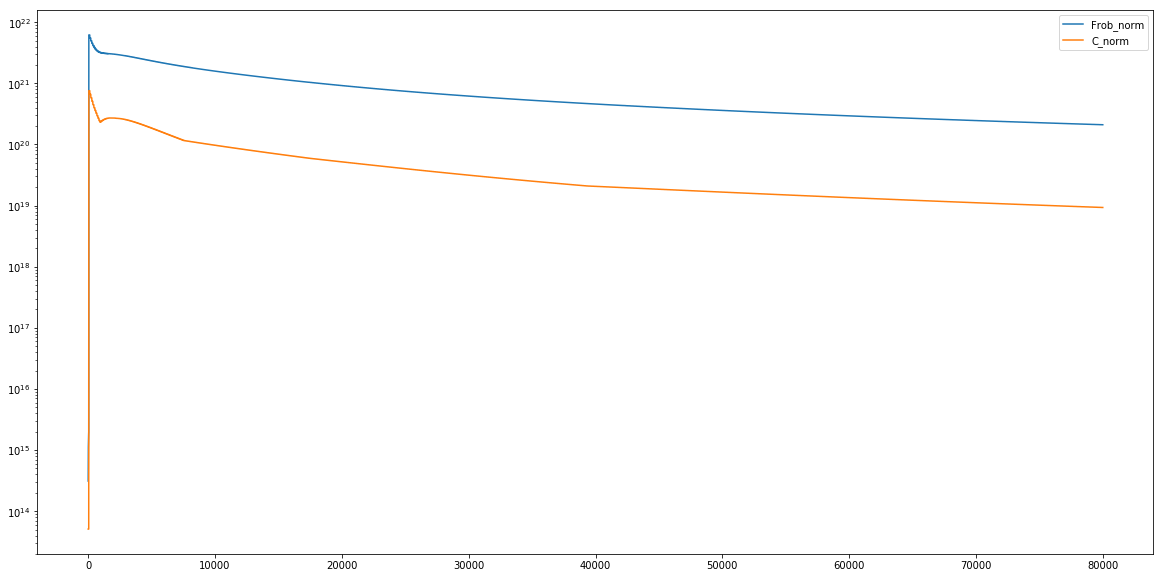

In [3]:
d = 71e-12

Mol = 40e-3 # kg / mol
Rg = 8.3144598  / Mol  # J / (kg * K) 

L = 80
N = 40
vmax = 2000.

n_l = 2e+23 
u_l = 400.
T_l = 300.

l = 1. / ((2 ** .5) * np.pi * n_l * d * d)

x_l = -20*l
x_r = 20*l

Tau = 1000

Mol = 40e-3
g = 5. / 3.
CFL = 0.5
M = u_l / ((g * Rg * T_l) ** .5)
    
hv = 2. * vmax / N
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
    
n_r = (g + 1.) * M * M / ((g - 1.) * M * M + 2.) * n_l
u_r = ((g - 1.) * M * M + 2.) / ((g + 1.) * M * M) * u_l
T_r = (2. * g * M * M - (g - 1.)) * ((g - 1.) * M * M + 2.) / ((g + 1) ** 2 * M * M) * T_l
   
    
F_l = F_m(vx-u_l, vy, vz, T_l, n_l, Mol)
F_r = F_m(vx-u_r, vy, vz, T_r, n_r, Mol)

J_ = J(F_l, vmax, N)

Flow = np.zeros((N, N, N))

Flow = rs(F_l, F_r, Flow, vx_, N)


S = solver(x_l = x_l, x_r = x_r, L = L, Tau = Tau, CFL = CFL, vmax = vmax,
           N = N, n_l = n_l, u_l = u_l, T_l = T_l)

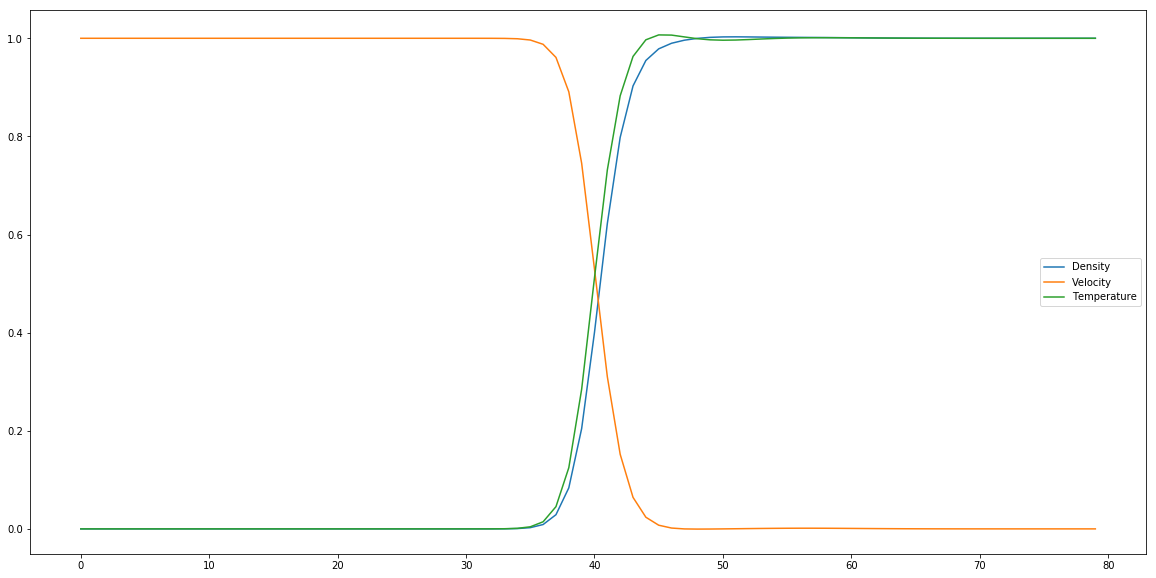

In [4]:
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.plot((S[1] - n_l) / (n_r - n_l))
line.set_label('Density')
line, = ax.plot((S[2] - u_r) / (u_l - u_r))
line.set_label('Velocity')
line, = ax.plot((S[3] - T_l) / (T_r - T_l))
line.set_label('Temperature')
ax.legend()

#Frob_norm = 2.4855822240924352e+17

#ax.plot(F_l[:, N/2, N/2])
#ax.plot(F_r[:, N/2, N/2])
#ax.plot(Flow[:, N/2, N/2])

#print vx_

#ax.plot(F_r[:, 10, 10])
#print n_l, n_r
#print u_l, u_r
#print T_l, T_r

In [11]:
t = tt.tensor()
dir(tt)
#?t.r()

In [5]:
print M

1.24076051934


Ааааа
$$
\begin{enumerate}
 \item f
\end{enumerate}
$$